# Import all essential libraries required for data preprocessing, modeling, and interpretability in this experiment.

In [365]:
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import and display the dataset to begin preprocessing and model development.

In [366]:
df = pd.read_csv("breast_cancer.csv")
df.head()

,Age,Race,Marital Status,Unnamed: 3,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,43,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N3,IIIC,Moderately differentiated; Grade II,Regional,40,Positive,Positive,19,11,1,Alive
1,47,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N2,IIIA,Moderately differentiated; Grade II,Regional,45,Positive,Positive,25,9,2,Alive
2,67,White,Married (including common law),NaN,T2,N1,IIB,Poorly differentiated; Grade III,Regional,25,Positive,Positive,4,1,2,Dead
3,46,White,Divorced,NaN,T1,N1,IIA,Moderately differentiated; Grade II,Regional,19,Positive,Positive,26,1,2,Dead
4,63,White,Married (including common law),NaN,T2,N2,IIIA,Moderately differentiated; Grade II,Regional,35,Positive,Positive,21,5,3,Dead


In [367]:
df.describe()

,Age,Unnamed: 3,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months
count,4024.000000,0.0,4024.000000,4024.000000,4024.000000,4024.000000
mean,53.972167,NaN,30.473658,14.357107,4.158052,71.297962
std,8.963134,NaN,21.119696,8.099675,5.109331,22.921430
min,30.000000,NaN,1.000000,1.000000,1.000000,1.000000
25%,47.000000,NaN,16.000000,9.000000,1.000000,56.000000
50%,54.000000,NaN,25.000000,14.000000,2.000000,73.000000
75%,61.000000,NaN,38.000000,19.000000,5.000000,90.000000
max,69.000000,NaN,140.000000,61.000000,46.000000,107.000000


# Convert the 'Survival Months' column to numeric format to ensure consistency and handle potential non-numeric values (just in case).

In [368]:
df['Survival Months'] = pd.to_numeric(df['Survival Months'], errors='coerce')

# Drop rows with missing survival months

In [369]:
df.dropna(subset=['Survival Months'], inplace=True)

# Create the new target: Survival_5yr

In [370]:
df['Survival_5yr'] = np.where(df['Survival Months'] >= 60, 1, 0)

# Drop original status and survival months to avoid leakage

In [371]:
df.drop(['Status', 'Survival Months'], axis=1, inplace=True)

# One-hot encode categorical columns

In [372]:
df_encoded = pd.get_dummies(df, drop_first=True)

# Assume df is your DataFrame and the target variable is in 'Survival_5yr'

In [373]:
X = df_encoded.drop('Survival_5yr', axis=1)
y = df_encoded['Survival_5yr']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train

In [374]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# Generate predictions using the trained model on test data and  Evaluate the model's performance

In [375]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6521739130434783

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.13      0.20       258
           1       0.69      0.90      0.78       547

    accuracy                           0.65       805
   macro avg       0.53      0.51      0.49       805
weighted avg       0.59      0.65      0.59       805


Confusion Matrix:
 [[ 34 224]
 [ 56 491]]


# ROC curve (Receiver Operating Characteristic curve) for a Random Forest model for top 10

In [376]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

base_model = RandomForestClassifier(random_state=42)
base_model.fit(X_train, y_train)

feat_importances = pd.Series(base_model.feature_importances_, index=X_train.columns)
top_features = feat_importances.sort_values(ascending=False).head(10).index

X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

best_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)
best_model.fit(X_train_top, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,5
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


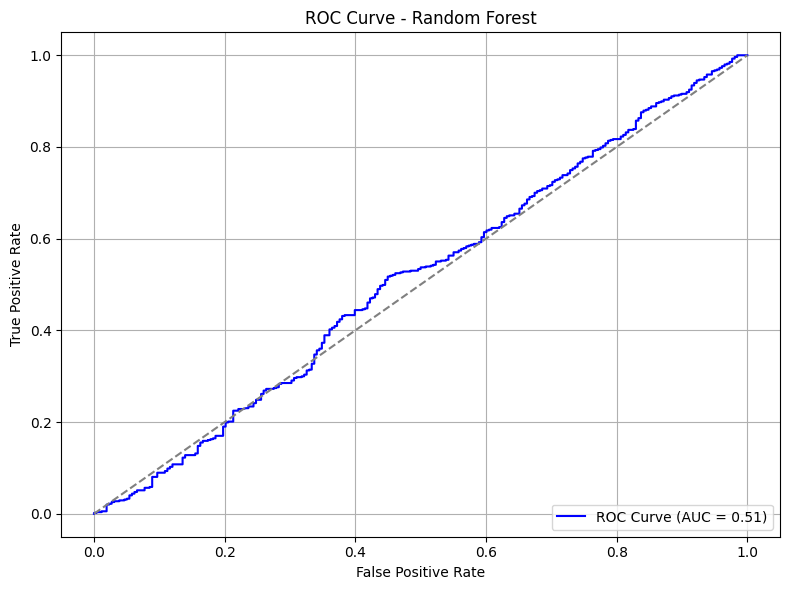

In [377]:
y_probs = best_model.predict_proba(X_test_top)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

In [378]:
importances = model.feature_importances_
feature_names = X.columns 
feat_importances = pd.Series(importances, index=feature_names)

# Select top 5 features and plot

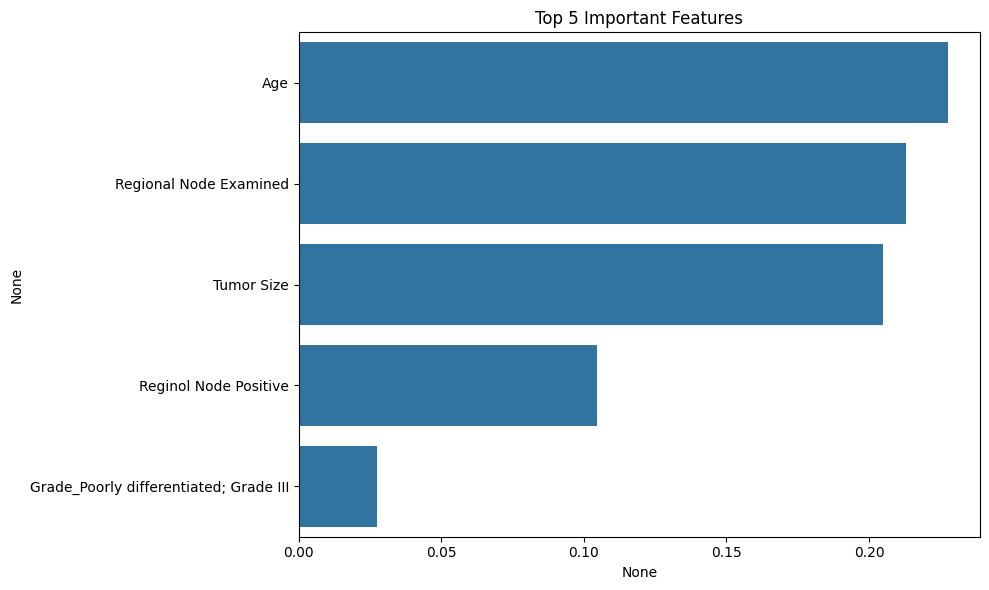

In [379]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances.sort_values(ascending=False)[:5],
            y=feat_importances.sort_values(ascending=False).index[:5])
plt.title("Top 5 Important Features")

plt.tight_layout()
plt.show()

# Training Model on Top 5 Important Features (Random Forest)

In [380]:
top_features = feat_importances.sort_values(ascending=False).head(5)

X_train_top = X_train[top_features.index]
X_test_top = X_test[top_features.index]

model_top = RandomForestClassifier(random_state=42)
model_top.fit(X_train_top, y_train)

y_pred = model_top.predict(X_test_top)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.34      0.17      0.22       258
           1       0.68      0.84      0.75       547

    accuracy                           0.63       805
   macro avg       0.51      0.51      0.49       805
weighted avg       0.57      0.63      0.58       805



# Select top 10 features and plot

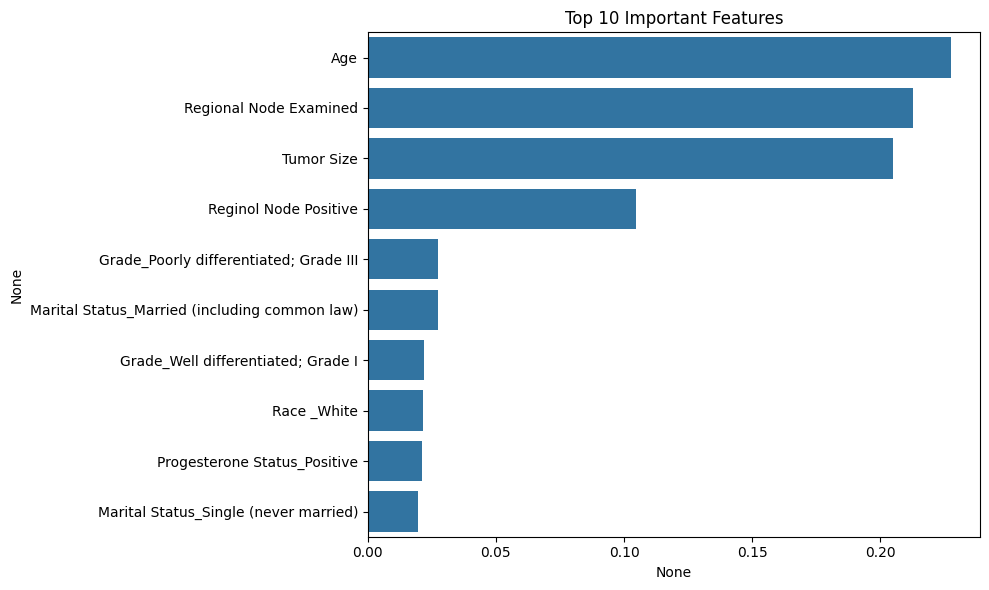

In [381]:
top_features = feat_importances.sort_values(ascending=False).head(10)
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances.sort_values(ascending=False)[:10],
            y=feat_importances.sort_values(ascending=False).index[:10])
plt.title("Top 10 Important Features")

plt.tight_layout()
plt.show()

# Training Model on Top 10 Important Features (Random Forest)

In [382]:
top_features = feat_importances.sort_values(ascending=False).head(10)

X_train_top = X_train[top_features.index]
X_test_top = X_test[top_features.index]

model_top = RandomForestClassifier(random_state=42)
model_top.fit(X_train_top, y_train)

y_pred = model_top.predict(X_test_top)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.40      0.16      0.23       258
           1       0.69      0.88      0.78       547

    accuracy                           0.65       805
   macro avg       0.54      0.52      0.50       805
weighted avg       0.60      0.65      0.60       805



## Hyperparameter tuning on a RandomForestClassifier using grid search with cross-validation to find the best combination of model parameters that gives the highest accuracy.

In [383]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Perform grid search
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit to training data
grid_search.fit(X_train_top, y_train)

# Print best hyperparameters
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Evaluate best model on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_top)
print(classification_report(y_test, y_pred))

Best Hyperparameters:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.46      0.05      0.09       258
           1       0.68      0.97      0.80       547

    accuracy                           0.68       805
   macro avg       0.57      0.51      0.45       805
weighted avg       0.61      0.68      0.58       805



## Create an explainer with the trained model, compute SHAP values for the test data, select the positive class values if binary classification, and plot feature importance using bar and detailed summary plots.

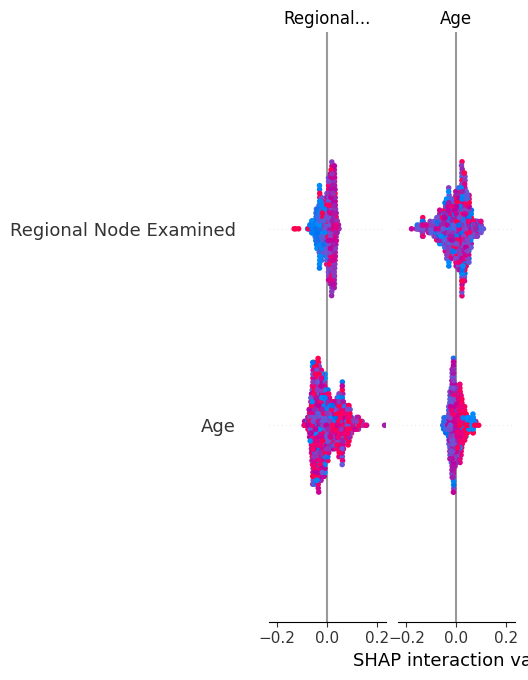

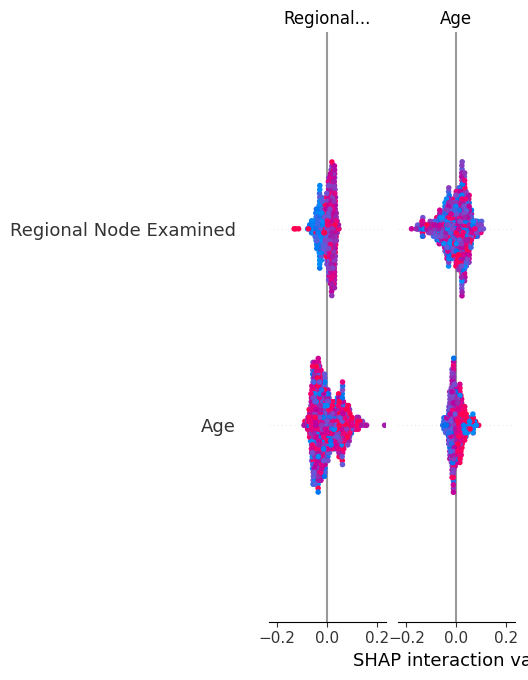

In [362]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_top)

if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]  
else:
    shap_values_to_plot = shap_values

shap.summary_plot(shap_values_to_plot, X_test_top, plot_type="bar")

shap.summary_plot(shap_values_to_plot, X_test_top)

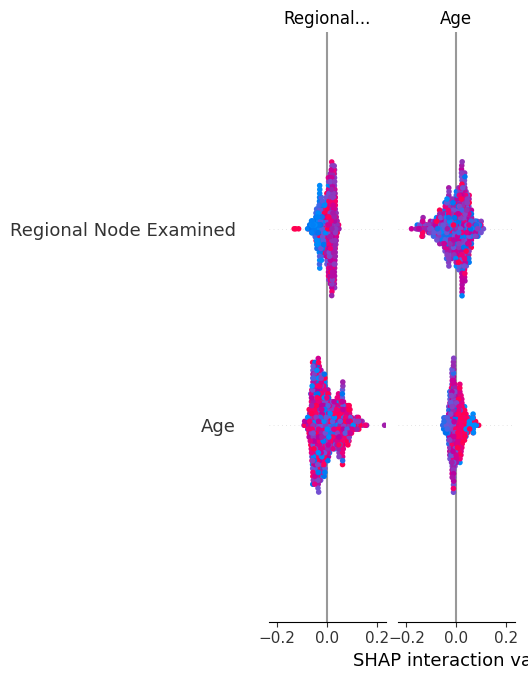

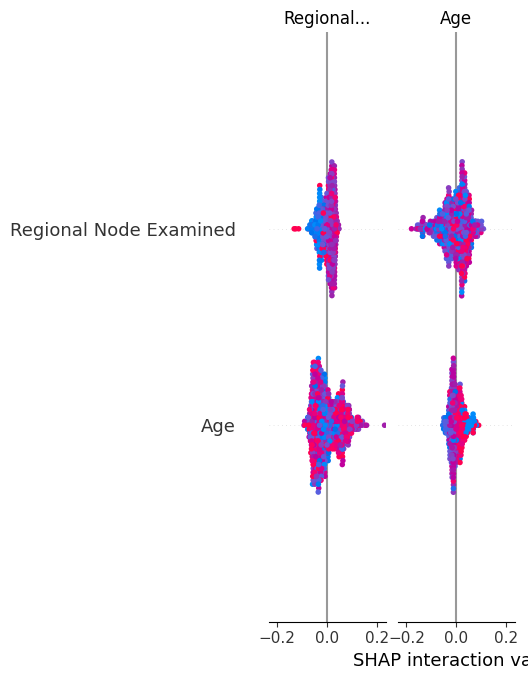

In [321]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_top)

if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]  
else:
    shap_values_to_plot = shap_values

shap.summary_plot(shap_values_to_plot, X_test_top, plot_type="bar")

shap.summary_plot(shap_values_to_plot, X_test_top)


## Load data and split it. Train RandomForest on all features. Select top 5 and 10 features. Retrain models on these subsets. Compute SHAP values and pick a sample to explain.

In [384]:
df = pd.read_csv("breast_cancer.csv")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)

top5_features = feat_importances.nlargest(5).index
top10_features = feat_importances.nlargest(10).index

X_train_top5 = X_train[top5_features]
X_test_top5 = X_test[top5_features]
X_train_top10 = X_train[top10_features]
X_test_top10 = X_test[top10_features]

model_top5 = RandomForestClassifier(random_state=42)
model_top5.fit(X_train_top5, y_train)

model_top10 = RandomForestClassifier(random_state=42)
model_top10.fit(X_train_top10, y_train)

explainer_top5 = shap.TreeExplainer(model_top5)
explainer_top10 = shap.TreeExplainer(model_top10)

shap_values_top5 = explainer_top5.shap_values(X_test_top5)[1]
shap_values_top10 = explainer_top10.shap_values(X_test_top10)[1]

sample_index = 0  

## Print and display waterfall plots for the top 5 and top 10 features using SHAP values for a chosen sample

🔍 SHAP Waterfall Plot: Top 5 Features


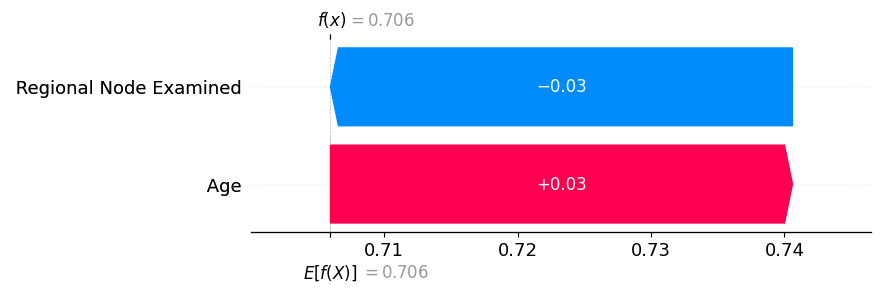

🔍 SHAP Waterfall Plot: Top 10 Features


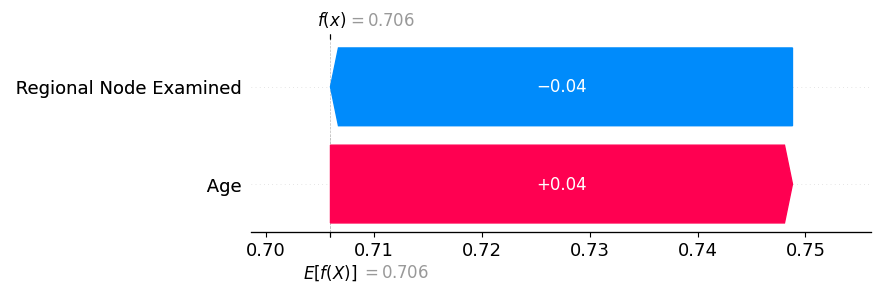

In [323]:
print("🔍 SHAP Waterfall Plot: Top 5 Features")
shap.plots._waterfall.waterfall_legacy(
    explainer_top5.expected_value[1],
    shap_values_top5[sample_index],
    X_test_top5.iloc[sample_index]
)

print("🔍 SHAP Waterfall Plot: Top 10 Features")
shap.plots._waterfall.waterfall_legacy(
    explainer_top10.expected_value[1],
    shap_values_top10[sample_index],
    X_test_top10.iloc[sample_index]
)